***Data Extraction***


In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [2]:
!pip install paddleocr paddlepaddle

In [3]:
# Root directory of the project
ROOT_DIR =  os.path.abspath("./")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to saved trained models
TRAINED_MODEL_PATH = os.path.join(MODEL_DIR, "barchart20250228T0935\\mask_rcnn_barchart_0099.h5") 

[2025/03/20 09:08:42] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\joice/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\joice/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

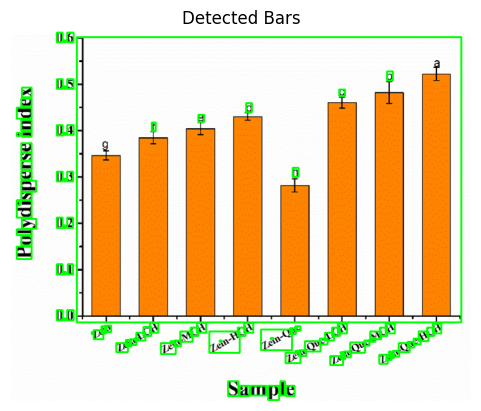

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Image path
image_path = "C:\\Users\\joice\\Downloads\\Mask_RCNN\\test_images\\supp fig 1.png"

# Perform OCR
results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []

for line in results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # Get X coordinate of text
        y_min = word_info[0][0][1]  # Get Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Sort text by X position (left to right)
text_boxes.sort()

# Merge words that belong to the same X-axis label
merged_labels = {}
for x, y, text in text_boxes:
    found = False
    for key in merged_labels.keys():
        if abs(key - x) < 50:  # If words are close in X, merge them
            merged_labels[key] += " " + text
            found = True
            break
    if not found:
        merged_labels[x] = text

# Load image for bar detection
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize contrast (helps with thresholding)
gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

# Apply thresholding for bar detection
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

# Detect contours (bars)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bars = [cv2.boundingRect(cnt) for cnt in contours]

# Sort bars from left to right
bars.sort(key=lambda b: b[0])

# Extract Y-axis labels and their positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if y not in y_axis_labels:
        try:
            y_axis_labels[y] = float(text)  # Convert to numeric values
        except ValueError:
            continue  # Ignore non-numeric text

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# Function to estimate bar value using interpolation
def estimate_value(y_pos, axis_mapping):
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pos >= sorted_keys[i + 1]:  # Between two known points
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pos - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If outside known range

# Analyze each bar and estimate values
bar_values = []
for (x, y, w, h) in bars:
    bar_top = y  # The top of the bar
    estimated_value = estimate_value(bar_top, axis_mapping)
    bar_values.append((x, estimated_value))
    print(f"Bar at x={x}: Estimated Value = {estimated_value}")

# Show the processed image with detected bars
for (x, y, w, h) in bars:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars")
plt.show()


[2025/03/18 14:55:29] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\joice/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\joice/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

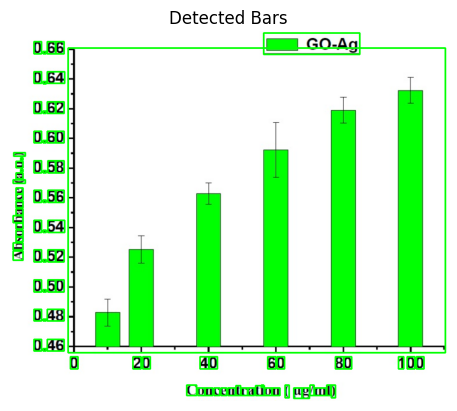

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Image path
image_path = "C:\\Users\\joice\\Downloads\\Mask_RCNN\\test_images\\PMC5707618___nanomaterials-07-00401-g005.jpg"

# Perform OCR
results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []

for line in results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # Get X coordinate of text
        y_min = word_info[0][0][1]  # Get Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Sort text by X position (left to right)
text_boxes.sort()

# Merge words that belong to the same X-axis label
merged_labels = {}
for x, y, text in text_boxes:
    found = False
    for key in merged_labels.keys():
        if abs(key - x) < 50:  # If words are close in X, merge them
            merged_labels[key] += " " + text
            found = True
            break
    if not found:
        merged_labels[x] = text

# Load image for bar detection
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize contrast (helps with thresholding)
gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

# Apply thresholding for bar detection
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

# Detect contours (bars)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bars = [cv2.boundingRect(cnt) for cnt in contours]

# Sort bars from left to right
bars.sort(key=lambda b: b[0])

# Extract Y-axis labels and their positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if y not in y_axis_labels:
        try:
            y_axis_labels[y] = float(text)  # Convert to numeric values
        except ValueError:
            continue  # Ignore non-numeric text

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# Function to estimate bar value using interpolation
def estimate_value(y_pos, axis_mapping):
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pos >= sorted_keys[i + 1]:  # Between two known points
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pos - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If outside known range

# Analyze each bar and estimate values
bar_values = []
for (x, y, w, h) in bars:
    bar_top = y  # The top of the bar
    estimated_value = estimate_value(bar_top, axis_mapping)
    bar_values.append((x, estimated_value))
    print(f"Bar at x={x}: Estimated Value = {estimated_value}")

# Show the processed image with detected bars
for (x, y, w, h) in bars:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars")
plt.show()

[2025/03/20 09:10:27] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\joice/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\joice/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

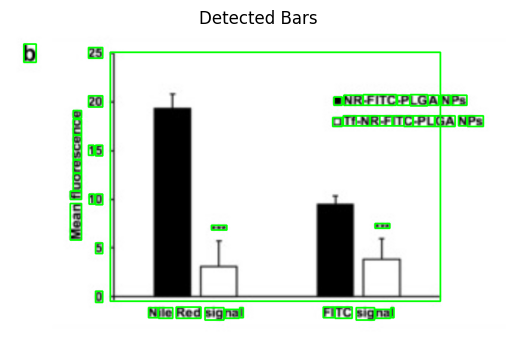

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Image path
image_path = "C:\\Users\\joice\\Downloads\\Mask_RCNN\\test_images\\Screenshot 2025-03-18 140713.png"

# Perform OCR
results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []

for line in results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # Get X coordinate of text
        y_min = word_info[0][0][1]  # Get Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Sort text by X position (left to right)
text_boxes.sort()

# Merge words that belong to the same X-axis label
merged_labels = {}
for x, y, text in text_boxes:
    found = False
    for key in merged_labels.keys():
        if abs(key - x) < 50:  # If words are close in X, merge them
            merged_labels[key] += " " + text
            found = True
            break
    if not found:
        merged_labels[x] = text

# Load image for bar detection
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize contrast (helps with thresholding)
gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

# Apply thresholding for bar detection
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

# Detect contours (bars)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bars = [cv2.boundingRect(cnt) for cnt in contours]

# Sort bars from left to right
bars.sort(key=lambda b: b[0])

# Extract Y-axis labels and their positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if y not in y_axis_labels:
        try:
            y_axis_labels[y] = float(text)  # Convert to numeric values
        except ValueError:
            continue  # Ignore non-numeric text

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# Function to estimate bar value using interpolation
def estimate_value(y_pos, axis_mapping):
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pos >= sorted_keys[i + 1]:  # Between two known points
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pos - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If outside known range

# Analyze each bar and estimate values
bar_values = []
for (x, y, w, h) in bars:
    bar_top = y  # The top of the bar
    estimated_value = estimate_value(bar_top, axis_mapping)
    bar_values.append((x, estimated_value))
    print(f"Bar at x={x}: Estimated Value = {estimated_value}")

# Show the processed image with detected bars
for (x, y, w, h) in bars:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars")
plt.show()






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.

Re-starting from epoch 99
Processing 1 images
image                    shape: (520, 843, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[2025/03/20 09:10:53] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\joice/.paddleocr/whl\\cls\\ch_ppocr_mobile_v

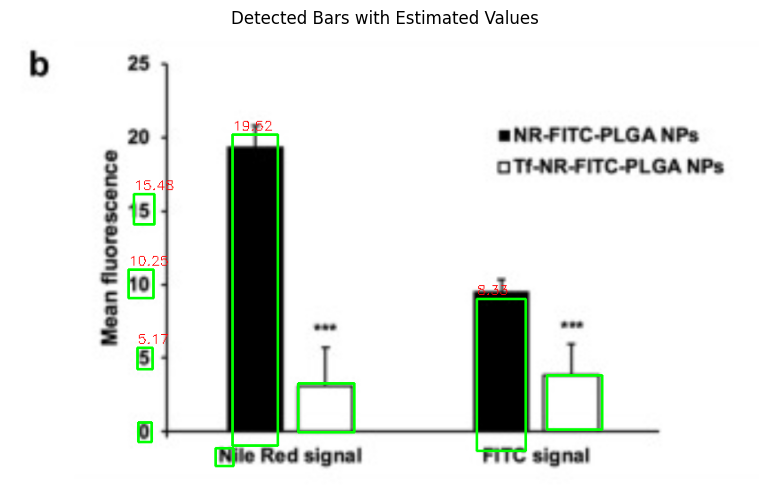

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from paddleocr import PaddleOCR
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# -------------------------------
# Load Mask R-CNN Configuration
# -------------------------------
class BarChartConfig(Config):
    NAME = "barchart"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 7  # Background + Bar

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Model and logs directory
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
TRAINED_MODEL_PATH = os.path.join(MODEL_DIR, "barchart20250228T0935/mask_rcnn_barchart_0099.h5")

# -------------------------------
# Load Mask R-CNN Model
# -------------------------------
model = modellib.MaskRCNN(mode="inference", config=BarChartConfig(), model_dir=MODEL_DIR)
model.load_weights(TRAINED_MODEL_PATH, by_name=True)

# -------------------------------
# Load Image & Preprocess
# -------------------------------
image_path = "C:\\Users\\joice\\Downloads\\Mask_RCNN\\test_images\\Screenshot 2025-03-18 140713.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# -------------------------------
# Perform Bar Detection using Mask R-CNN
# -------------------------------
results = model.detect([image_rgb], verbose=1)
r = results[0]

# Extract detected bar bounding boxes
bars = []
for i in range(len(r['rois'])):
    y1, x1, y2, x2 = r['rois'][i]  # Extract bar coordinates
    bars.append((x1, y1, x2 - x1, y2 - y1))  # Convert to (x, y, width, height)

# Sort bars from left to right
bars.sort(key=lambda b: b[0])

# -------------------------------
# Perform OCR for Y-Axis Labels
# -------------------------------
ocr = PaddleOCR(use_angle_cls=True, lang="en")
ocr_results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []
for line in ocr_results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # X coordinate of text
        y_min = word_info[0][0][1]  # Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Extract Y-axis labels and positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if x < image.shape[1] * 0.2:  # Filter Y-axis labels on the left
        try:
            y_axis_labels[y] = float(text)  # Convert text to numeric values
        except ValueError:
            continue  # Ignore non-numeric values

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# -------------------------------
# Convert Bar Pixel Positions to Values
# -------------------------------
def pixel_to_value(y_pixel, axis_mapping):
    """Convert Y-pixel position to actual numerical value using interpolation."""
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pixel >= sorted_keys[i + 1]:  # Find matching range
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pixel - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If out of range

# Estimate values for each detected bar
bar_values = []
for idx, (x, y, w, h) in enumerate(bars):
    bar_top = y  # Get the top of the bar
    estimated_value = pixel_to_value(bar_top, axis_mapping)
    bar_values.append((idx + 1, estimated_value))  # Use bar index instead of X position
    print(f"Bar {idx + 1}: Estimated Value = {estimated_value}")

# -------------------------------
# Visualization of Detected Bars
# -------------------------------
image_result = image.copy()
for (x, y, w, h), (idx, value) in zip(bars, bar_values):
    cv2.rectangle(image_result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if value is not None:
        cv2.putText(image_result, f"{value}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Show processed image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars with Estimated Values")
plt.show()


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# -------------------------------
# Load Mask R-CNN Configuration
# -------------------------------
class BarChartConfig(Config):
    NAME = "barchart"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 8  # Adjust this if needed
    DETECTION_MIN_CONFIDENCE = 0.5  # 🔥 Lowered to detect more bars

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Model and logs directory
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
TRAINED_MODEL_PATH = os.path.join(MODEL_DIR, "barchart20250228T0935/mask_rcnn_barchart_0099.h5")

# -------------------------------
# Load Mask R-CNN Model
# -------------------------------
model = modellib.MaskRCNN(mode="inference", config=BarChartConfig(), model_dir=MODEL_DIR)
model.load_weights(TRAINED_MODEL_PATH, by_name=True)

# -------------------------------
# Load Image & Preprocess
# -------------------------------
image_path = "/mnt/data/image.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocess image (optional: increase contrast)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)  # 🔥 Improves bar visibility
image_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)  # Convert back to RGB

# -------------------------------
# Perform Bar Detection using Mask R-CNN
# -------------------------------
results = model.detect([image_rgb], verbose=1)
r = results[0]

# Extract detected bar bounding boxes
bars = []
for i in range(len(r['rois'])):
    y1, x1, y2, x2 = r['rois'][i]  # Extract bar coordinates
    bars.append((x1, y1, x2 - x1, y2 - y1))  # Convert to (x, y, width, height)

# 🔹 Step: Merge Nearby Bars (if needed)
bars.sort(key=lambda b: b[0])  # Sort left to right
merged_bars = []
for i, (x, y, w, h) in enumerate(bars):
    if i > 0 and abs(x - merged_bars[-1][0]) < 20:  # If bars are very close, merge them
        prev_x, prev_y, prev_w, prev_h = merged_bars.pop()
        new_x = min(prev_x, x)
        new_y = min(prev_y, y)
        new_w = max(prev_x + prev_w, x + w) - new_x
        new_h = max(prev_y + prev_h, y + h) - new_y
        merged_bars.append((new_x, new_y, new_w, new_h))
    else:
        merged_bars.append((x, y, w, h))

# -------------------------------
# Perform OCR for Y-Axis Labels
# -------------------------------
ocr = PaddleOCR(use_angle_cls=True, lang="en")
ocr_results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []
for line in ocr_results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # X coordinate of text
        y_min = word_info[0][0][1]  # Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Extract Y-axis labels and positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if x < image.shape[1] * 0.2:  # Filter Y-axis labels on the left
        try:
            y_axis_labels[y] = float(text)  # Convert text to numeric values
        except ValueError:
            continue  # Ignore non-numeric values

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# -------------------------------
# Convert Bar Pixel Positions to Values
# -------------------------------
def pixel_to_value(y_pixel, axis_mapping):
    """Convert Y-pixel position to actual numerical value using interpolation."""
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pixel >= sorted_keys[i + 1]:  # Find matching range
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pixel - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If out of range

# Estimate values for each detected bar
bar_values = []
for idx, (x, y, w, h) in enumerate(merged_bars):
    bar_top = y  # Get the top of the bar
    estimated_value = pixel_to_value(bar_top, axis_mapping)
    bar_values.append((idx + 1, estimated_value))  # Use bar index instead of X position
    print(f"Bar {idx + 1}: Estimated Value = {estimated_value}")

# -------------------------------
# Visualization of Detected Bars
# -------------------------------
image_result = image.copy()
for (x, y, w, h), (idx, value) in zip(merged_bars, bar_values):
    cv2.rectangle(image_result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if value is not None:
        cv2.putText(image_result, f"{value}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Show processed image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars with Estimated Values")
plt.show()


ValueError: Dimension 1 in both shapes must be equal, but are 36 and 32. Shapes are [1024,36] and [1024,32]. for 'Assign_1372' (op: 'Assign') with input shapes: [1024,36], [1024,32].

Re-starting from epoch 99
Processing 1 images
image                    shape: (572, 715, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[2025/03/18 15:28:18] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\joice/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\

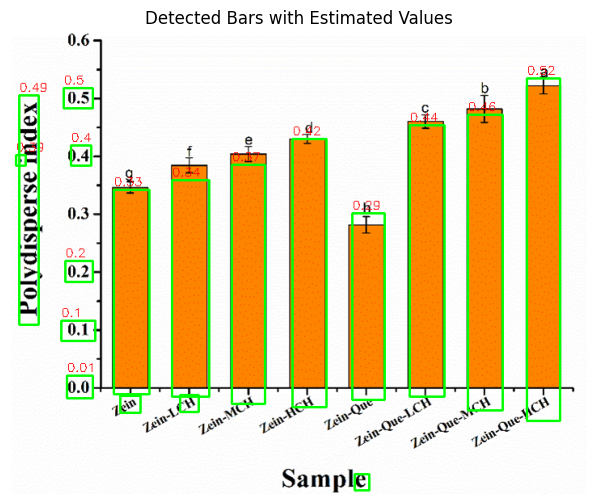

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from paddleocr import PaddleOCR
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# -------------------------------
# Load Mask R-CNN Configuration
# -------------------------------
class BarChartConfig(Config):
    NAME = "barchart"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 7  # Background + Bar

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Model and logs directory
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
TRAINED_MODEL_PATH = os.path.join(MODEL_DIR, "barchart20250228T0935/mask_rcnn_barchart_0099.h5")

# -------------------------------
# Load Mask R-CNN Model
# -------------------------------
model = modellib.MaskRCNN(mode="inference", config=BarChartConfig(), model_dir=MODEL_DIR)
model.load_weights(TRAINED_MODEL_PATH, by_name=True)

# -------------------------------
# Load Image & Preprocess
# -------------------------------
image_path = "C:\\Users\\joice\\Downloads\\Mask_RCNN\\test_images\\supp fig 1.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# -------------------------------
# Perform Bar Detection using Mask R-CNN
# -------------------------------
results = model.detect([image_rgb], verbose=1)
r = results[0]

# Extract detected bar bounding boxes
bars = []
for i in range(len(r['rois'])):
    y1, x1, y2, x2 = r['rois'][i]  # Extract bar coordinates
    bars.append((x1, y1, x2 - x1, y2 - y1))  # Convert to (x, y, width, height)

# Sort bars from left to right
bars.sort(key=lambda b: b[0])

# -------------------------------
# Perform OCR for Y-Axis Labels
# -------------------------------
ocr = PaddleOCR(use_angle_cls=True, lang="en")
ocr_results = ocr.ocr(image_path, cls=True)

# Store detected text with positions
text_boxes = []
for line in ocr_results:
    for word_info in line:
        text, confidence = word_info[1][0], word_info[1][1]
        x_min = word_info[0][0][0]  # X coordinate of text
        y_min = word_info[0][0][1]  # Y coordinate of text
        text_boxes.append((x_min, y_min, text))

# Extract Y-axis labels and positions
y_axis_labels = {}
for x, y, text in text_boxes:
    if x < image.shape[1] * 0.2:  # Filter Y-axis labels on the left
        try:
            y_axis_labels[y] = float(text)  # Convert text to numeric values
        except ValueError:
            continue  # Ignore non-numeric values

# Sort Y-axis labels by pixel position (top to bottom)
sorted_y = sorted(y_axis_labels.items(), key=lambda item: item[0], reverse=True)

# Map Y-axis labels to pixel positions
axis_mapping = {y: value for y, value in sorted_y}

# -------------------------------
# Convert Bar Pixel Positions to Values
# -------------------------------
def pixel_to_value(y_pixel, axis_mapping):
    """Convert Y-pixel position to actual numerical value using interpolation."""
    sorted_keys = sorted(axis_mapping.keys(), reverse=True)  # Top-to-bottom order
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] >= y_pixel >= sorted_keys[i + 1]:  # Find matching range
            y1, v1 = sorted_keys[i], axis_mapping[sorted_keys[i]]
            y2, v2 = sorted_keys[i + 1], axis_mapping[sorted_keys[i + 1]]
            estimated_value = v1 + (v2 - v1) * ((y_pixel - y1) / (y2 - y1))
            return round(estimated_value, 2)
    return None  # If out of range

# Estimate values for each detected bar
bar_values = []
for idx, (x, y, w, h) in enumerate(bars):
    bar_top = y  # Get the top of the bar
    estimated_value = pixel_to_value(bar_top, axis_mapping)
    bar_values.append((idx + 1, estimated_value))  # Use bar index instead of X position
    print(f"Bar {idx + 1}: Estimated Value = {estimated_value}")

# -------------------------------
# Visualization of Detected Bars
# -------------------------------
image_result = image.copy()
for (x, y, w, h), (idx, value) in zip(bars, bar_values):
    cv2.rectangle(image_result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if value is not None:
        cv2.putText(image_result, f"{value}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Show processed image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Bars with Estimated Values")
plt.show()